# This is an Notebook which can evalute multiple files.  It implements a number of features:

- TopK
- Removing recent referrals
- Thresholding 
- Tables and visualization
- Config files for standardized processes. 



In [21]:
%reload_ext autoreload
%autoreload 2
#ignore warnings.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#imports
import pandas as pd
import os, sys
import importlib
import yaml, json
from pathlib import Path

#path append
sys.path.append(os.path.join(Path.cwd(), 'modules'))
import Evaluate, Helper, Present, Score, Synthetic


<H3> Imports</H3>

### File configuration
<p> Just edit the configuration file path/address. And inside the config.yaml file in 'config' folder, you can edit prediection, referral and result file addresses.</p>

In [29]:
config_file = 'config/config.yaml'
prediction_files = ['config/predictions/pred1.yaml', 'config/predictions/pred2.yaml']
generate_data=False


### Load Configuration and Referrals

In [28]:
#Load Configuration
c_r, c_e, c_gen, c_aws, c_visual, predictions=Helper.load_configuration(config_file, prediction_files)
#Generate Data (if required)
if generate_data:
    Synthetic.generate_synthetic_event_data(c_gen) #uncomment if you want to generate synthetic data
    Synthetic.generate_synthetic_prediction_data(c_gen)   #uncomment if you want to generate synthetic data
#Load Referral Data
referrals=Helper.read_file(directory=c_r['dir'],file=c_r['file'],file_format=c_r['file_format'],aws=c_r['aws'],bucket= c_r['bucket'])
referrals


Reading file ./data/simulated_prediction_data/referrals.csv


,person_id,date
0,30,2017-01-29
1,53,2016-05-17
2,120,2016-02-27
3,154,2016-08-31
4,158,2016-08-29
5,204,2017-09-29
6,233,2017-08-10
7,279,2016-11-27
8,294,2016-08-20
9,325,2017-04-19


### Evaluate Models
For each configuration file provided it will evaluate the models. 

Reading file ./data/simulated_prediction_data/predictions.csv


,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,precision_@k=50,precision_@k=60,recall_@k=50,recall_@k=60,accuracy_@k=50,accuracy_@k=60,balanced_acc_@k=50,balanced_acc_@k=60,f1_score_@k=50,f1_score_@k=60,log_loss_@k=50,log_loss_@k=60,roc_auc_score_@k=50,roc_auc_score_@k=60,brier_score_loss_@k=50,brier_score_loss_@k=60,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,2016/10-2017/07,2017-01-01,495,442.00000,49.00000,3.00000,1.00000,433.00000,58.00000,2.00000,2.00000,0.02000,0.03333,0.25000,0.50000,0.25000,0.50000,0.57510,0.69094,0.03704,0.06250,0.98694,0.98694,0.52749,0.52749,0.32991,0.32991,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:06.227575-04:00,2020-05-28 11:21:06.263637-04:00,00:00:00.036062
1,Version 1.0,lin_reg,2017/01-2017/04,2017-01-01,495,442.00000,49.00000,3.00000,1.00000,433.00000,58.00000,2.00000,2.00000,0.02000,0.03333,0.25000,0.50000,0.25000,0.50000,0.57510,0.69094,0.03704,0.06250,0.98694,0.98694,0.52749,0.52749,0.32991,0.32991,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:06.267047-04:00,2020-05-28 11:21:06.279509-04:00,00:00:00.012462
2,Version 1.0,lin_reg,2017/01-2017/07,2017-01-01,495,442.00000,49.00000,3.00000,1.00000,433.00000,58.00000,2.00000,2.00000,0.02000,0.03333,0.25000,0.50000,0.25000,0.50000,0.57510,0.69094,0.03704,0.06250,0.98694,0.98694,0.52749,0.52749,0.32991,0.32991,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:06.280542-04:00,2020-05-28 11:21:06.292775-04:00,00:00:00.012233
3,Version 1.0,lin_reg,2017/01-2018/01,2017-01-01,495,439.00000,49.00000,6.00000,1.00000,430.00000,58.00000,5.00000,2.00000,0.02000,0.03333,0.14286,0.28571,0.14286,0.28571,0.52122,0.58343,0.03509,0.05970,0.98211,0.98211,0.59456,0.59456,0.32780,0.32780,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:06.293738-04:00,2020-05-28 11:21:06.306366-04:00,00:00:00.012628
4,Version 1.0,rand_forest,2016/10-2017/07,2017-01-01,495,443.00000,48.00000,2.00000,2.00000,433.00000,58.00000,2.00000,2.00000,0.04000,0.03333,0.50000,0.50000,0.50000,0.50000,0.70112,0.69094,0.07407,0.06250,0.98813,0.98813,0.64358,0.64358,0.32953,0.32953,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:06.307350-04:00,2020-05-28 11:21:06.319681-04:00,00:00:00.012331
5,Version 1.0,rand_forest,2017/01-2017/04,2017-01-01,495,443.00000,48.00000,2.00000,2.00000,433.00000,58.00000,2.00000,2.00000,0.04000,0.03333,0.50000,0.50000,0.50000,0.50000,0.70112,0.69094,0.07407,0.06250,0.98813,0.98813,0.64358,0.64358,0.32953,0.32953,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:06.320671-04:00,2020-05-28 11:21:06.333336-04:00,00:00:00.012665
6,Version 1.0,rand_forest,2017/01-2017/07,2017-01-01,495,443.00000,48.00000,2.00000,2.00000,433.00000,58.00000,2.00000,2.00000,0.04000,0.03333,0.50000,0.50000,0.50000,0.50000,0.70112,0.69094,0.07407,0.06250,0.98813,0.98813,0.64358,0.64358,0.32953,0.32953,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:06.334441-04:00,2020-05-28 11:21:06.348267-04:00,00:00:00.013826
7,Version 1.0,rand_forest,2017/01-2018/01,2017-01-01,495,440.00000,48.00000,5.00000,2.00000,430.00000,58.00000,5.00000,2.00000,0.04000,0.03333,0.28571,0.28571,0.28571,0.28571,0.59368,0.58343,0.07018,0.05970,0.98659,0.98659,0.61300,0.61300,0.32879,0.32879,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./res

Reading file ./data/simulated_prediction_data/predictions2.csv


,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,precision_@k=50,precision_@k=60,recall_@k=50,recall_@k=60,accuracy_@k=50,accuracy_@k=60,balanced_acc_@k=50,balanced_acc_@k=60,f1_score_@k=50,f1_score_@k=60,log_loss_@k=50,log_loss_@k=60,roc_auc_score_@k=50,roc_auc_score_@k=60,brier_score_loss_@k=50,brier_score_loss_@k=60,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,2016/10-2017/07,2017-01-01,495,442.00000,49.00000,3.00000,1.00000,433.00000,58.00000,2.00000,2.00000,0.02000,0.03333,0.25000,0.50000,0.25000,0.50000,0.57510,0.69094,0.03704,0.06250,0.98694,0.98694,0.52749,0.52749,0.32991,0.32991,./data/simulated_prediction_data/predictions2.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:10.023949-04:00,2020-05-28 11:21:10.061069-04:00,00:00:00.037120
1,Version 1.0,lin_reg,2017/01-2017/04,2017-01-01,495,442.00000,49.00000,3.00000,1.00000,433.00000,58.00000,2.00000,2.00000,0.02000,0.03333,0.25000,0.50000,0.25000,0.50000,0.57510,0.69094,0.03704,0.06250,0.98694,0.98694,0.52749,0.52749,0.32991,0.32991,./data/simulated_prediction_data/predictions2.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:10.064405-04:00,2020-05-28 11:21:10.077140-04:00,00:00:00.012735
2,Version 1.0,lin_reg,2017/01-2017/07,2017-01-01,495,442.00000,49.00000,3.00000,1.00000,433.00000,58.00000,2.00000,2.00000,0.02000,0.03333,0.25000,0.50000,0.25000,0.50000,0.57510,0.69094,0.03704,0.06250,0.98694,0.98694,0.52749,0.52749,0.32991,0.32991,./data/simulated_prediction_data/predictions2.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:10.078127-04:00,2020-05-28 11:21:10.091054-04:00,00:00:00.012927
3,Version 1.0,lin_reg,2017/01-2018/01,2017-01-01,495,439.00000,49.00000,6.00000,1.00000,430.00000,58.00000,5.00000,2.00000,0.02000,0.03333,0.14286,0.28571,0.14286,0.28571,0.52122,0.58343,0.03509,0.05970,0.98211,0.98211,0.59456,0.59456,0.32780,0.32780,./data/simulated_prediction_data/predictions2.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:10.092146-04:00,2020-05-28 11:21:10.105465-04:00,00:00:00.013319
4,Version 1.0,rand_forest,2016/10-2017/07,2017-01-01,495,443.00000,48.00000,2.00000,2.00000,433.00000,58.00000,2.00000,2.00000,0.04000,0.03333,0.50000,0.50000,0.50000,0.50000,0.70112,0.69094,0.07407,0.06250,0.98813,0.98813,0.64358,0.64358,0.32953,0.32953,./data/simulated_prediction_data/predictions2.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:10.106550-04:00,2020-05-28 11:21:10.119075-04:00,00:00:00.012525
5,Version 1.0,rand_forest,2017/01-2017/04,2017-01-01,495,443.00000,48.00000,2.00000,2.00000,433.00000,58.00000,2.00000,2.00000,0.04000,0.03333,0.50000,0.50000,0.50000,0.50000,0.70112,0.69094,0.07407,0.06250,0.98813,0.98813,0.64358,0.64358,0.32953,0.32953,./data/simulated_prediction_data/predictions2.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:10.120056-04:00,2020-05-28 11:21:10.132955-04:00,00:00:00.012899
6,Version 1.0,rand_forest,2017/01-2017/07,2017-01-01,495,443.00000,48.00000,2.00000,2.00000,433.00000,58.00000,2.00000,2.00000,0.04000,0.03333,0.50000,0.50000,0.50000,0.50000,0.70112,0.69094,0.07407,0.06250,0.98813,0.98813,0.64358,0.64358,0.32953,0.32953,./data/simulated_prediction_data/predictions2.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-05-28 11:21:10.133882-04:00,2020-05-28 11:21:10.146253-04:00,00:00:00.012371
7,Version 1.0,rand_forest,2017/01-2018/01,2017-01-01,495,440.00000,48.00000,5.00000,2.00000,430.00000,58.00000,5.00000,2.00000,0.04000,0.03333,0.28571,0.28571,0.28571,0.28571,0.59368,0.58343,0.07018,0.05970,0.98659,0.98659,0.61300,0.61300,0.32879,0.32879,./data/simulated_prediction_data/predictions2.csv,./data/simulated_prediction_data/referrals.c

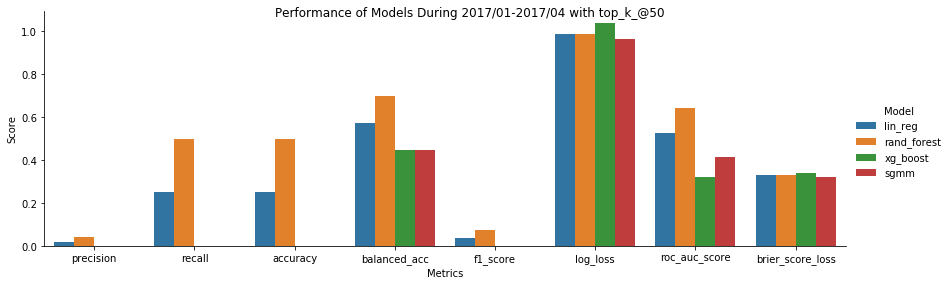

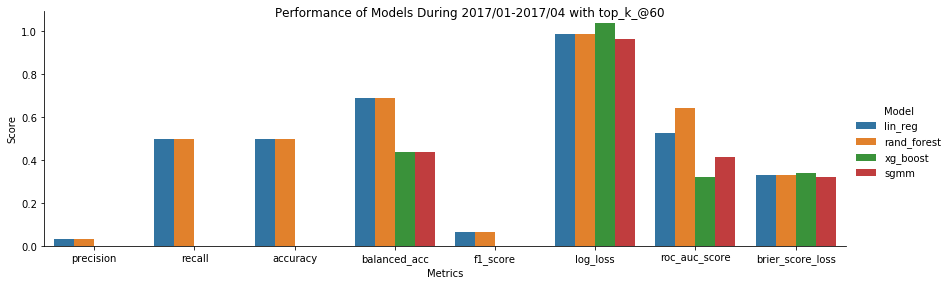

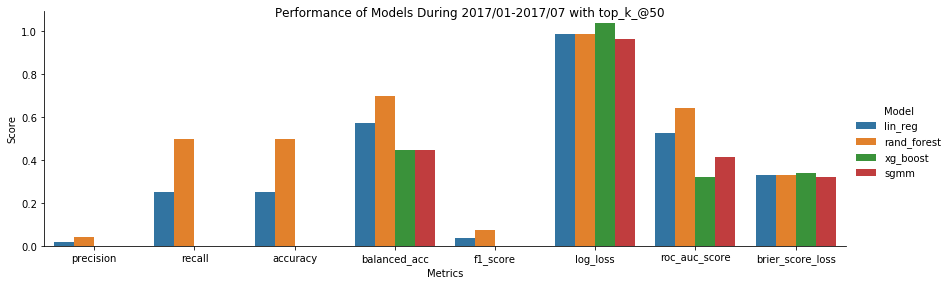

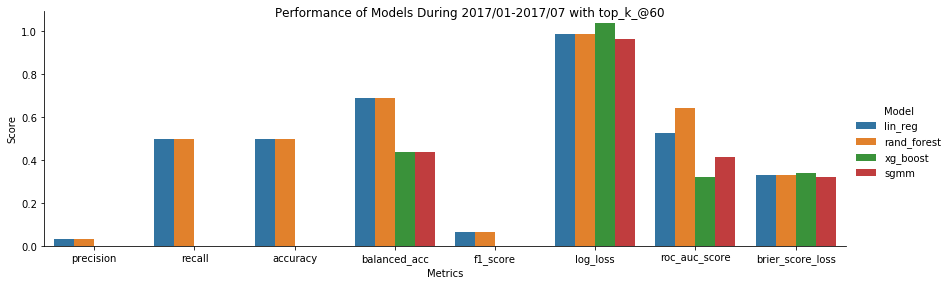

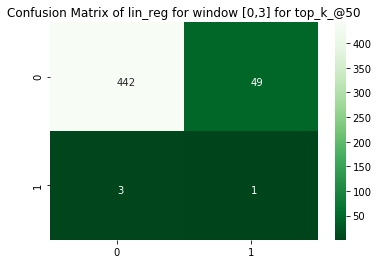

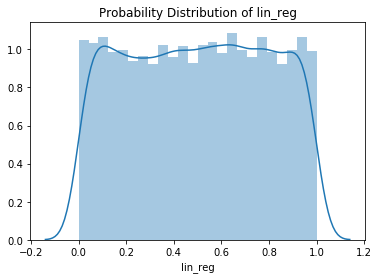

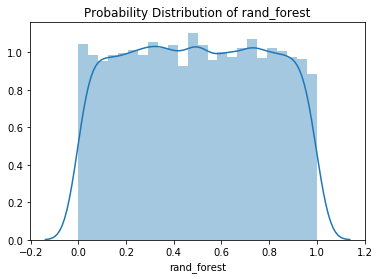

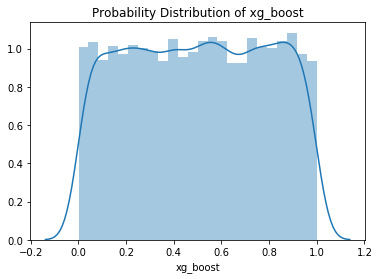

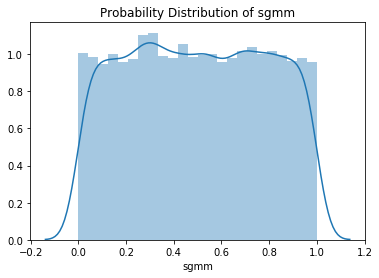

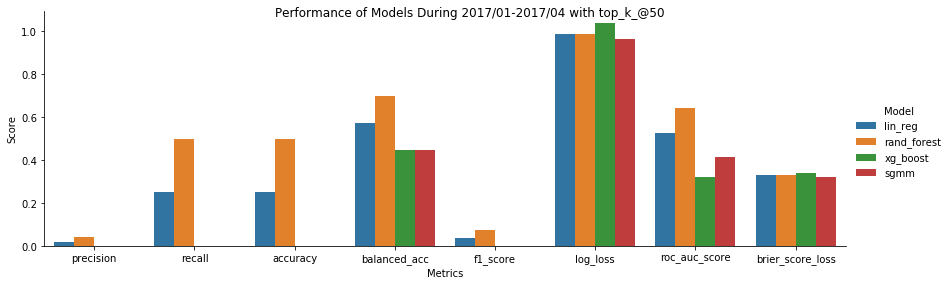

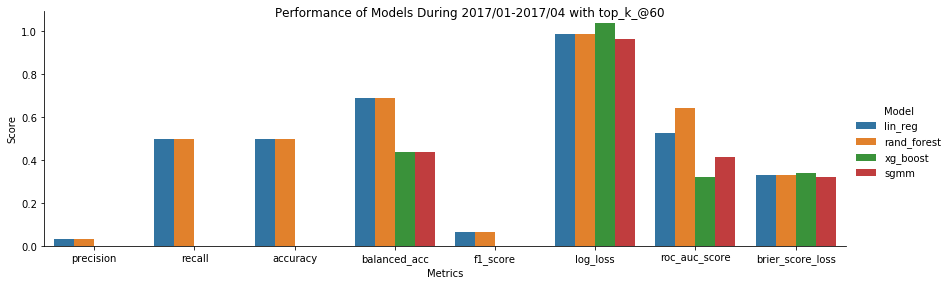

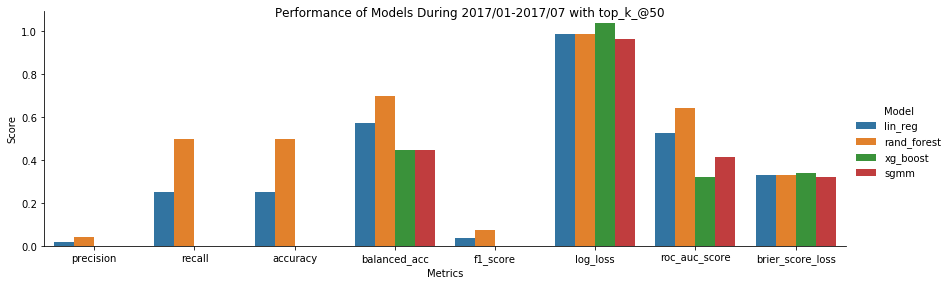

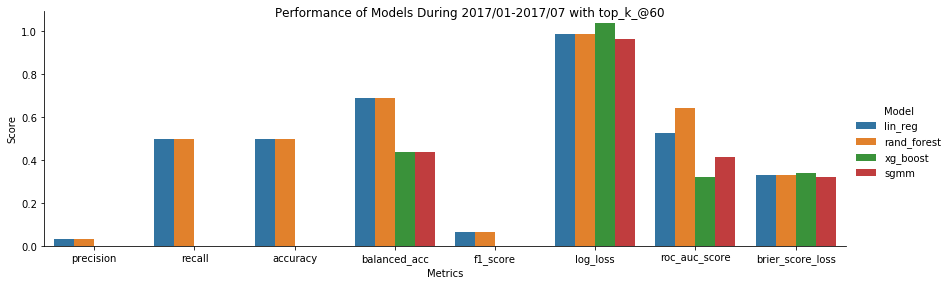

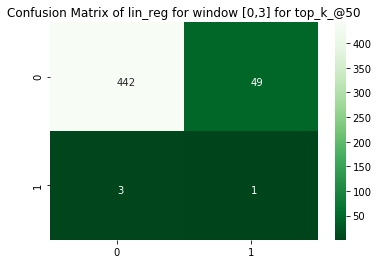

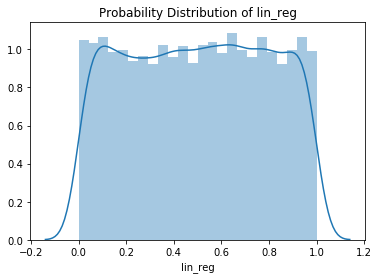

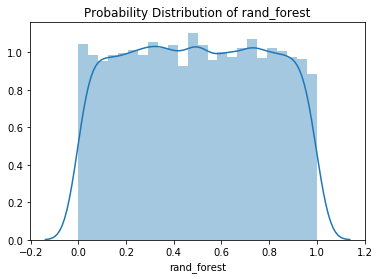

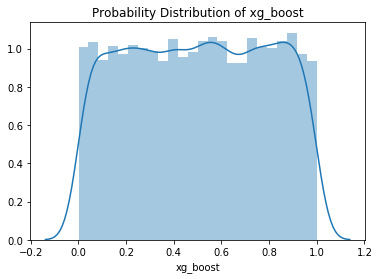

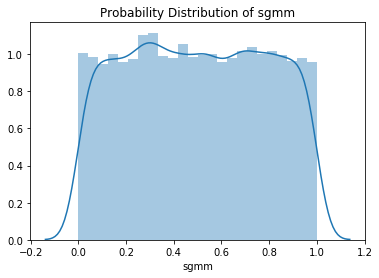

In [30]:
for c_p in predictions:    
    all_model_evaluations = Evaluate.evaluate(c_p, c_e, c_r, referrals) 
    Present.present_evaluation(c_p, c_r, c_e, c_visual, all_model_evaluations)
    